In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sklearn.preprocessing as preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import scipy.stats as stats

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

# Load Data

In [2]:
dataset = pd.read_csv('02 Stroke Prediction.csv')
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Explore Data

In [3]:
dataset.shape

(5110, 12)

In [4]:
dataset.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
any(dataset['id'].value_counts() > 1)

False

In [6]:
dataset.drop('id', axis=1, inplace=True)
dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
categorical_col = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
class_col = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
target_col = 'stroke'
num_col = [feature for feature in dataset 
           if feature not in categorical_col + [target_col]]

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
gender
Female    58.6
Male      41.4
Other      0.0
Name: count, dtype: float64


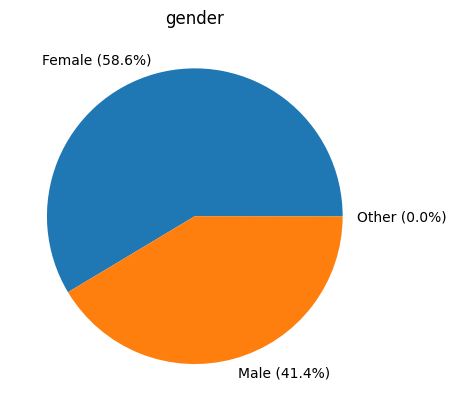

hypertension
0    4612
1     498
Name: count, dtype: int64
hypertension
0    90.3
1     9.7
Name: count, dtype: float64


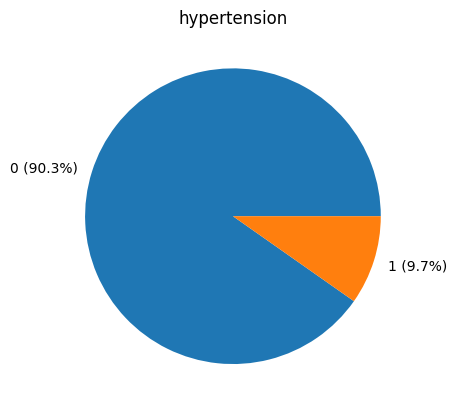

heart_disease
0    4834
1     276
Name: count, dtype: int64
heart_disease
0    94.6
1     5.4
Name: count, dtype: float64


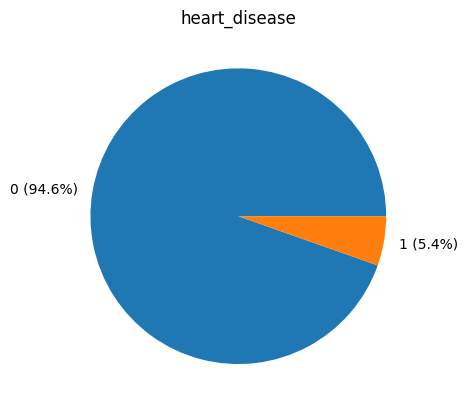

ever_married
Yes    3353
No     1757
Name: count, dtype: int64
ever_married
Yes    65.6
No     34.4
Name: count, dtype: float64


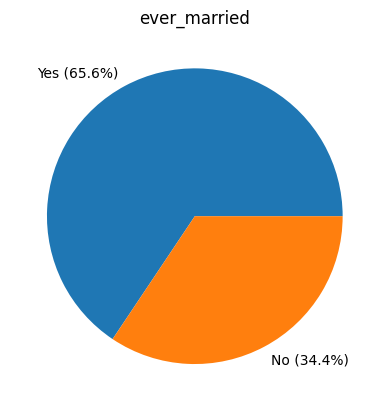

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
work_type
Private          57.2
Self-employed    16.0
children         13.4
Govt_job         12.9
Never_worked      0.4
Name: count, dtype: float64


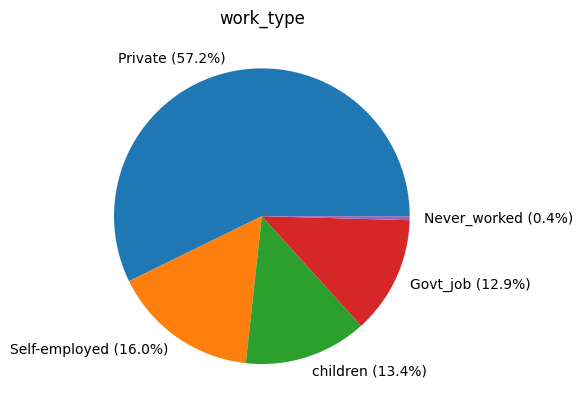

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
Residence_type
Urban    50.8
Rural    49.2
Name: count, dtype: float64


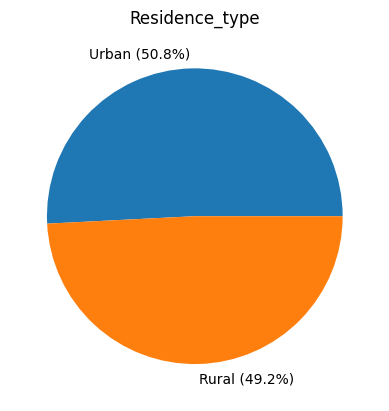

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64
smoking_status
never smoked       37.0
Unknown            30.2
formerly smoked    17.3
smokes             15.4
Name: count, dtype: float64


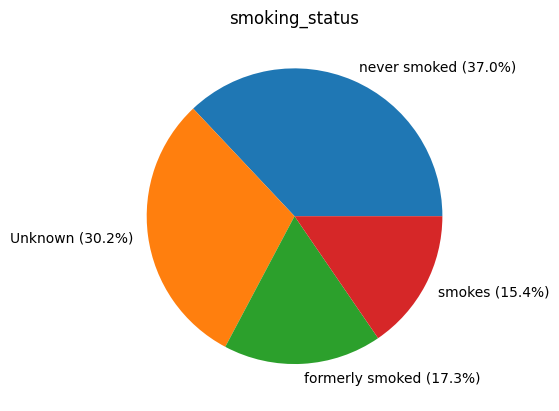

stroke
0    4861
1     249
Name: count, dtype: int64
stroke
0    95.1
1     4.9
Name: count, dtype: float64


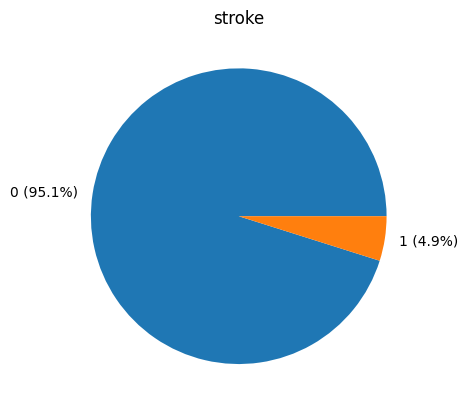

In [8]:
for feature in categorical_col + ['stroke']:
    values = dataset[feature].value_counts()
    print(values)
    ratio = round(values/values.sum()*100, 1)
    print(ratio)
    labels = []
    for value in values.index:
        label = f'{value} ({ratio[value]}%)'
        labels.append(label)
    
    plt.pie(values, labels = labels)
    plt.title(feature)
    plt.show()

age
Min:0.08
Max:82.0
Mean:43.226614481409


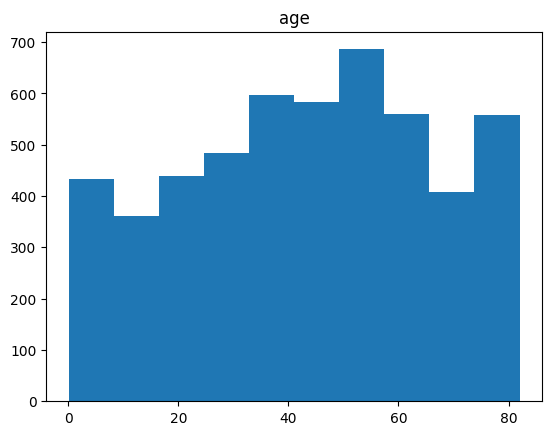

avg_glucose_level
Min:55.12
Max:271.74
Mean:106.1476771037182


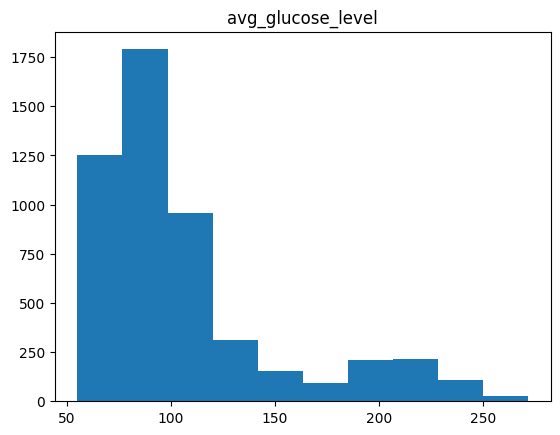

bmi
Min:10.3
Max:97.6
Mean:28.893236911794666


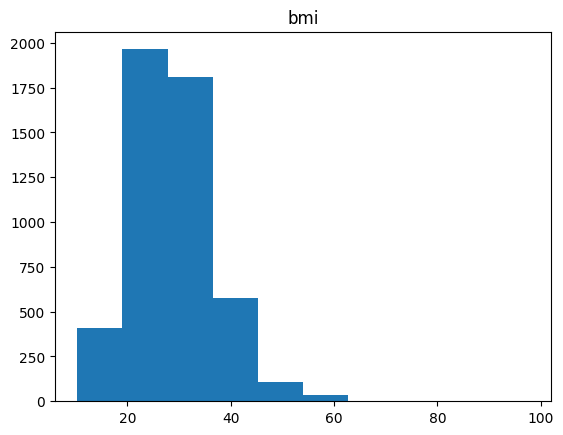

In [9]:
for feature in dataset:
    if feature not in categorical_col + ['stroke']:
        values = dataset[feature]
        print(feature)
        print(f'Min:{values.min()}')
        print(f'Max:{values.max()}')
        print(f'Mean:{values.mean()}')
        plt.hist(values)
        plt.title(feature)
        plt.show()

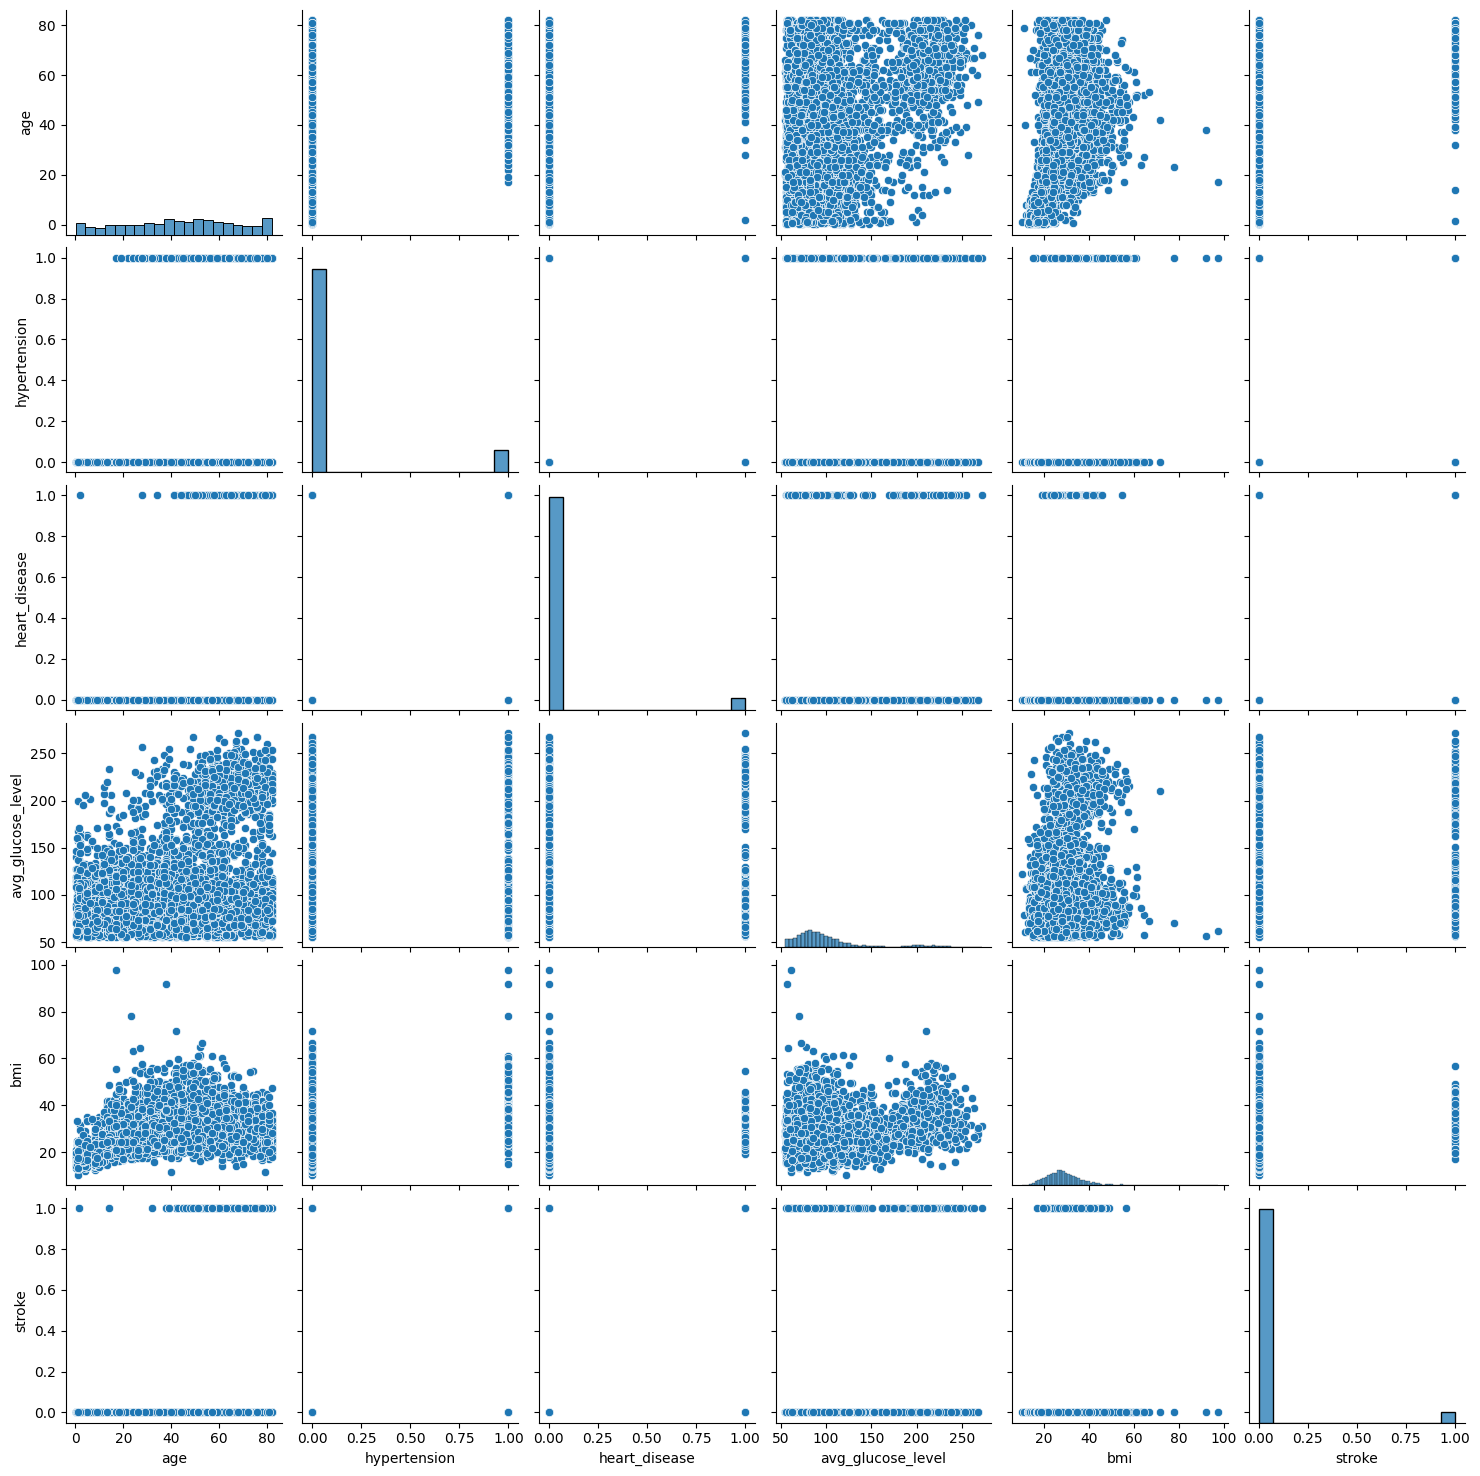

In [10]:
sns.pairplot(dataset)

In [11]:
dataset.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

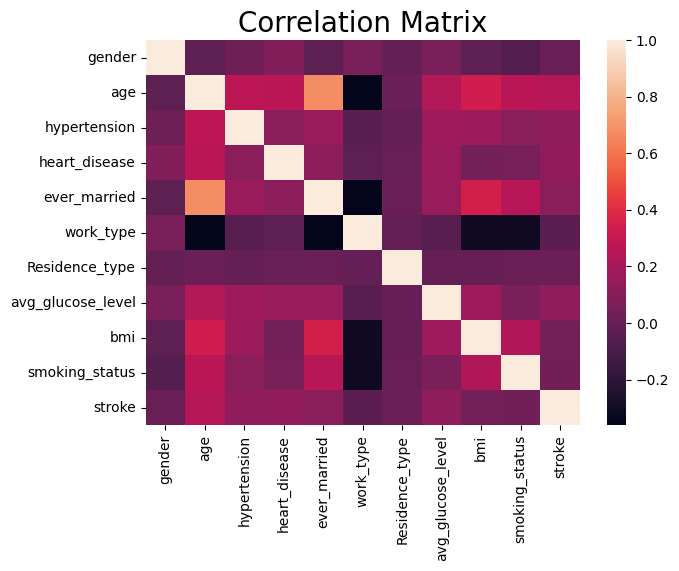

In [12]:
dataset_correlation_plot = dataset.copy()

le = preprocessing.LabelEncoder()
for feature in class_col:
    le.fit(dataset_correlation_plot[feature])
    dataset_correlation_plot[feature]  = le.transform(dataset_correlation_plot[feature])

f, ax = plt.subplots(figsize=[7, 5])
ax.set_title("Correlation Matrix", fontsize=20)
sns.heatmap(dataset_correlation_plot.corr())
plt.show()

# Prepocessing

In [13]:
preprocessed_dataset = dataset.copy()

In [14]:
def median_target(dataset, variable, col_target):
    temp = dataset[dataset[variable].notna()]
    temp = temp[[variable, col_target]].groupby([col_target])[[variable]].median().reset_index()
    return temp

In [15]:
rows_with_na_bmi = dataset['bmi'].isna()
median_target_values = median_target(preprocessed_dataset, 'bmi', target_col)

preprocessed_dataset.loc[(dataset['stroke'] == 0) & rows_with_na_bmi, 'bmi'] = median_target_values.iloc[0]['bmi']
preprocessed_dataset.loc[(dataset['stroke'] == 1) & rows_with_na_bmi, 'bmi'] = median_target_values.iloc[1]['bmi']

In [16]:
preprocessed_dataset.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [17]:
preprocessed_dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.7,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [18]:
dataset[dataset['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [19]:
preprocessed_dataset.drop(dataset[dataset['gender'] == 'Other'].index, inplace=True)
preprocessed_dataset.shape

(5109, 11)

In [19]:
preprocessed_dataset = pd.get_dummies(preprocessed_dataset, columns=class_col, dtype=int)
preprocessed_dataset.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,29.7,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0


In [20]:
scaler = preprocessing.StandardScaler()
preprocessed_dataset[num_col] = scaler.fit_transform(preprocessed_dataset[num_col])
preprocessed_dataset.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.051242,0,1,2.706450,1.003624,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,0.785889,0,0,2.121652,0.107453,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
2,1.626174,0,1,-0.004867,0.471117,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,0.255182,0,0,1.437473,0.717889,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,1.581949,1,0,1.501297,-0.632863,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0


# Model

In [21]:
y = preprocessed_dataset[target_col]
X = preprocessed_dataset.drop(target_col, axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [23]:
def my_grid_search(X, y, classificator, parm_grid):
    
    n_cpu = os.cpu_count()
        
    grid_search = GridSearchCV(
        classificator, param_grid=param_grid, scoring='f1', cv=5, n_jobs=n_cpu, verbose=10
    )
    grid_search.fit(X, y)
    return grid_search

In [24]:
def my_randomized_search(X, y, classificator, parm_dist, n_iter=30):
    
    n_cpu = os.cpu_count()
        
    random_search = RandomizedSearchCV(
        classificator, param_distributions=param_dist, n_iter=n_iter, random_state=42,
        scoring='f1', cv=5, n_jobs=n_cpu, verbose=10
    )
    random_search.fit(X, y)
    return random_search

In [25]:
def print_search_results(random_search):
    results = random_search.cv_results_
    index_first = list(results['rank_test_score']).index(1)
    print('mean F1 Score')
    print(results['mean_test_score'][index_first])
    print('Std F1 Score')
    print(results['std_test_score'][index_first])
    print('Params')
    print(results['params'][index_first])

In [26]:
def print_test_result(y_true, y_pred, labels):
    print('F1 score:')
    print(f1_score(y_true, y_pred))
    print('accuracy score:')
    print(accuracy_score(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

In [27]:
def print_results(model):
    print_search_results(model)

    print('--------------------------------------------------')
    print('metrics on train set')
    y_pred = model.predict(X_train)
    print_test_result(y_train, y_pred, model.classes_)
    
    print('metrics on test set')
    y_pred = model.predict(X_test)
    print_test_result(y_test, y_pred, model.classes_)

    
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    y_pred_proba = probs[:,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_proba)
    ap=average_precision_score(y_test, y_pred_proba)
    plt.plot(recall,precision,label="Logistic Regression, ap="+str(ap))
    plt.legend(loc=4)
    plt.show()

## KNN

Fitting 5 folds for each of 406 candidates, totalling 2030 fits
mean F1 Score
0.06999147485080989
Std F1 Score
0.06022666448864816
Params
{'n_neighbors': 1, 'weights': 'uniform'}
--------------------------------------------------
metrics on train set
F1 score:
1.0
accuracy score:
1.0


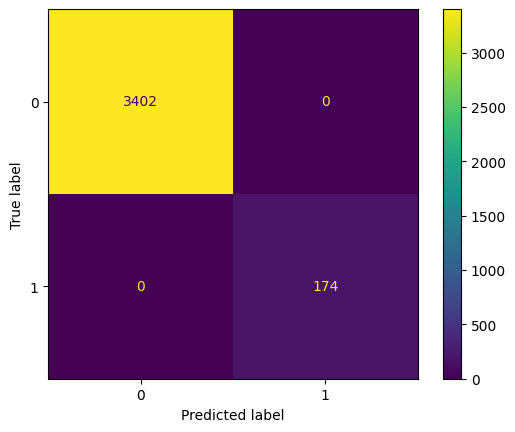

metrics on test set
F1 score:
0.06015037593984963
accuracy score:
0.918460534898891


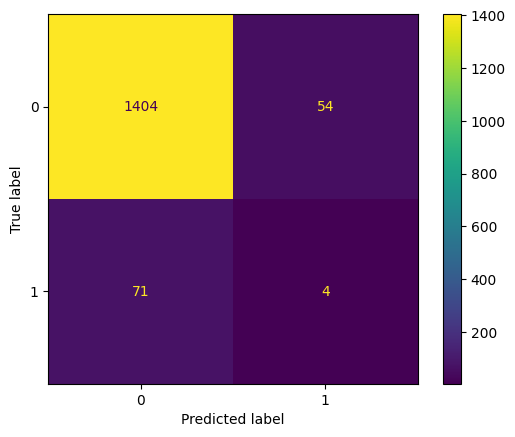

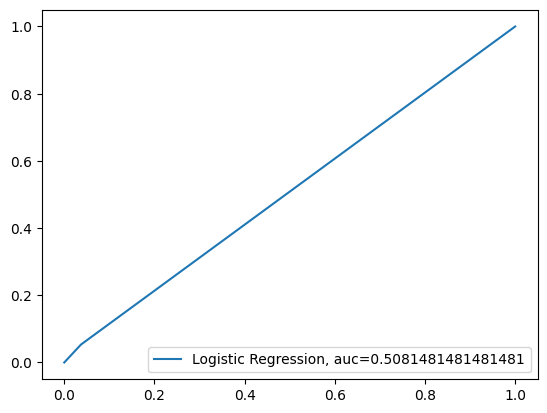

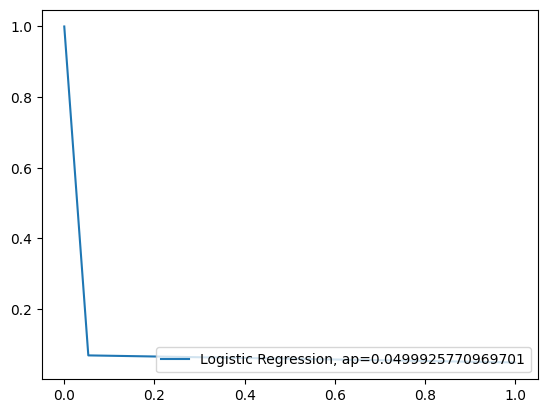

In [28]:
#knn
knn = KNN()
param_grid = {
    "n_neighbors": [1,2,3,4] + list(range(5,1000, 5)),
    "weights":["uniform", "distance"]
}

knn_search = my_grid_search(X_train, y_train, knn, param_grid)
print_results(knn_search)

## Logistic Regression

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\inna2\miniconda3\envs\AI4BH\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


mean F1 Score
0.2266466112941509
Std F1 Score
0.021797979230695864
Params
{'class_weight': 'balanced', 'max_iter': 10, 'penalty': 'l1'}
--------------------------------------------------
metrics on train set
F1 score:
0.23797881010594946
accuracy score:
0.7385346756152126


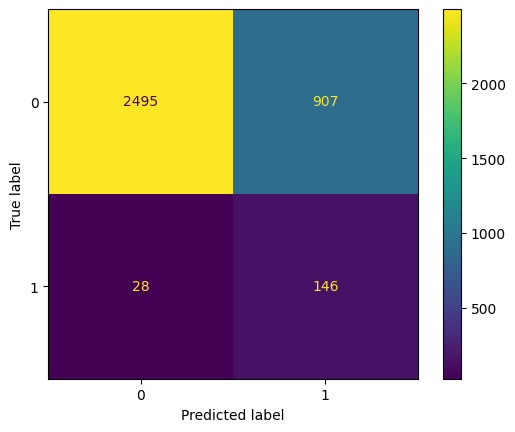

metrics on test set
F1 score:
0.220532319391635
accuracy score:
0.7325505544683627


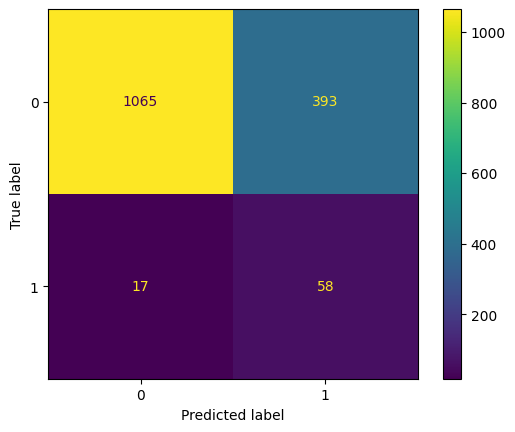

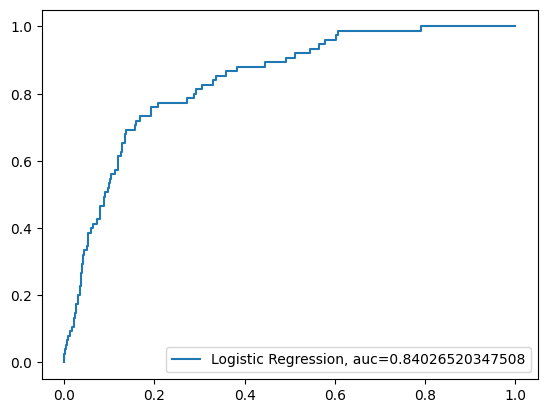

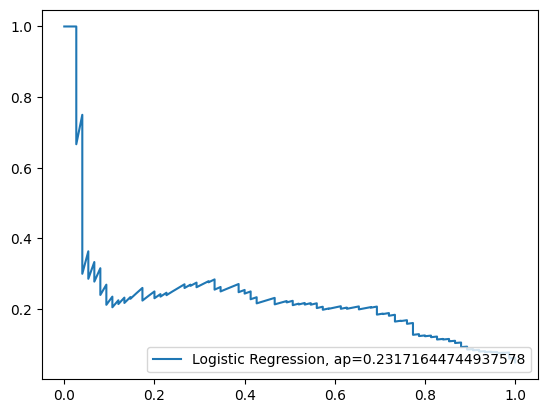

In [29]:
logit = LogisticRegression(solver='saga', random_state=42)
param_grid={
    'penalty':[None,'l2', 'l1'],
    'max_iter': [10, 50, 100, 150, 200, 250, 300, 500, 1000, 2500],
    'class_weight': [None, 'balanced']
}

logistic_search = my_grid_search(X_train, y_train, logit, param_grid)
print_results(logistic_search)

## Random Forest

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
mean F1 Score
0.021637426900584796
Std F1 Score
0.026516453915215513
Params
{'max_depth': 165, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 56}
--------------------------------------------------
metrics on train set
F1 score:
0.9942196531791908
accuracy score:
0.9994407158836689


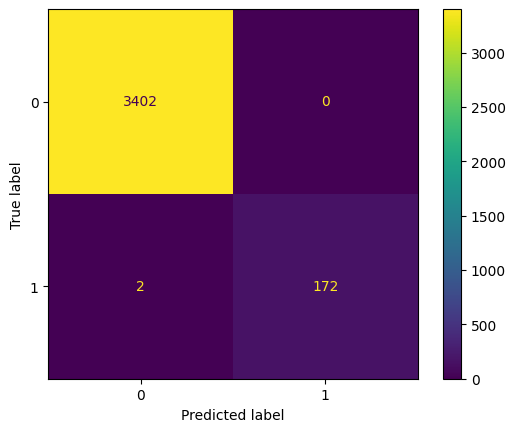

metrics on test set
F1 score:
0.025316455696202535
accuracy score:
0.9497716894977168


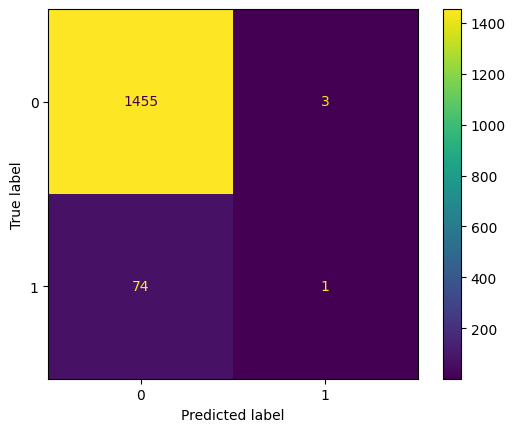

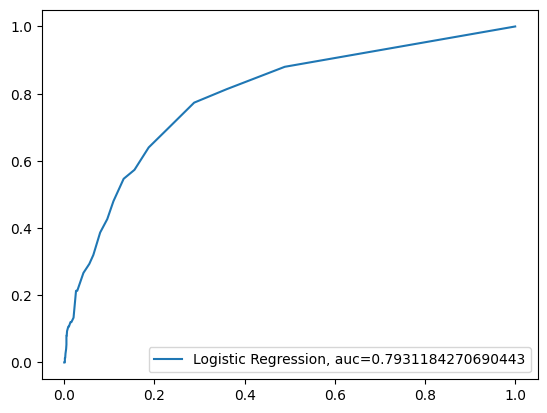

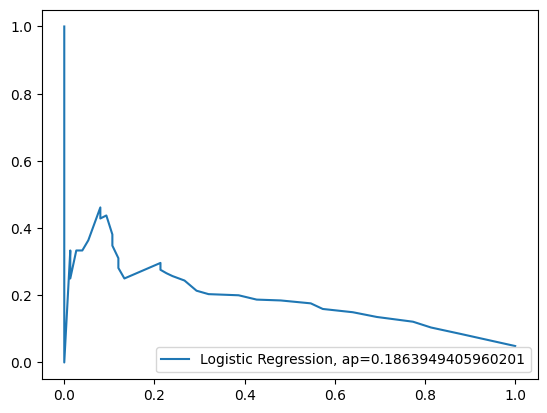

In [30]:
dtc = RandomForestClassifier( random_state=42)
param_dist={
    'n_estimators':stats.randint(low=10, high=300),
    'max_depth':stats.randint(low=1, high=200),
    'min_samples_leaf':stats.randint(low=1, high=20),
    'min_samples_split':stats.randint(low=2, high=20)
}

random_forest_search = my_randomized_search(X_train, y_train, dtc, param_dist, n_iter=1000)
print_results(random_forest_search)

## SVM

Fitting 5 folds for each of 275 candidates, totalling 1375 fits
mean F1 Score
0.1208941545783651
Std F1 Score
0.03955870421633725
Params
{'C': 8.0, 'degree': 5}
--------------------------------------------------
metrics on train set
F1 score:
0.6564885496183206
accuracy score:
0.9748322147651006


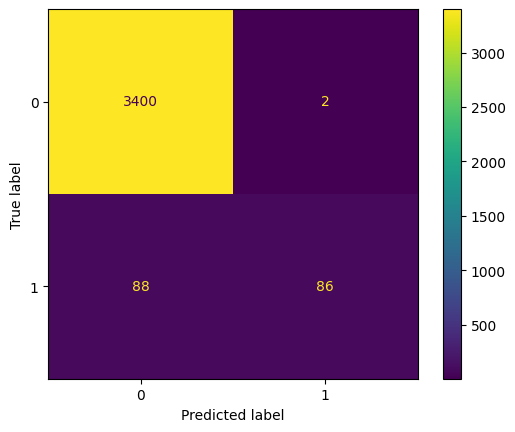

metrics on test set
F1 score:
0.14634146341463414
accuracy score:
0.9315068493150684


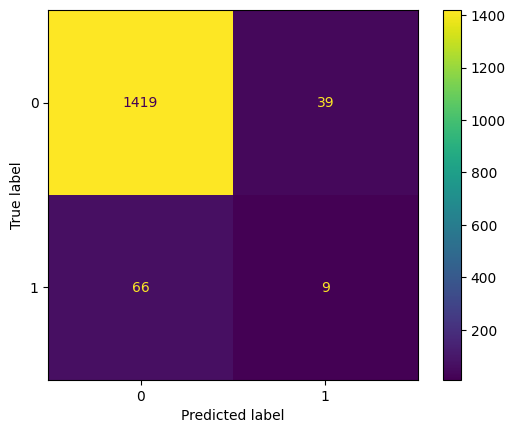

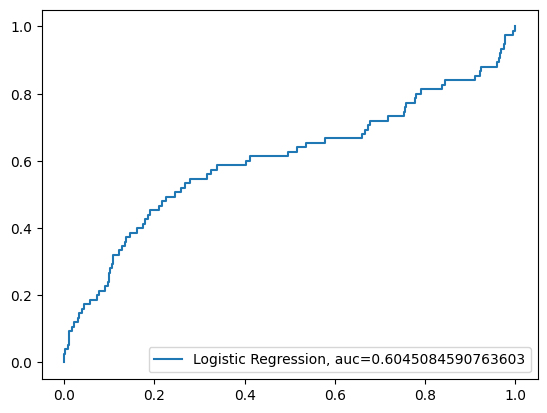

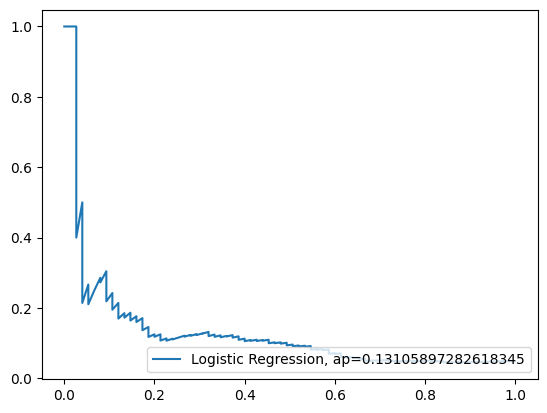

In [32]:
svm = SVC(kernel='poly', random_state=42, probability=True)
param_grid={
    'C':np.linspace(0.4,10,25),
    'degree': range(0,11)
}

svm_search = my_grid_search(X_train, y_train, svm, param_grid)
print_results(svm_search)